In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import numpy as np

from pdg.pdg import PDG
from pdg.rv import Variable as Var
from pdg.dist import RawJointDist as RJD, CPT

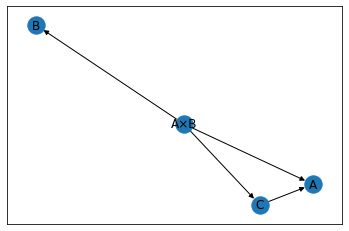

In [299]:
A = Var.alph("A", 3)
B = Var.alph("B", 2)
C = Var.alph("C", 3)

M = PDG()
M += A,B,C

M += CPT.make_random(A&B, C)
M += CPT.make_random(C, A)

M.draw()

In [38]:
best = M.optimize_score(0)
M.score(best, gamma=0)

0.09430601763027362

### **Warmup:** no marginalization or conditioning; $p$ same shape as $\mu$.

In [292]:
M.dshape
n = np.prod(M.dshape)

mu = cp.Variable(n, nonneg=True)
p_special = best.data.reshape(-1)
t = cp.Variable(n)
        

tol_constraints = [
#         cp.constraints.exponential.ExpCone(-t[L], mu, fix(p).reshape(-1)) 
        cp.constraints.exponential.ExpCone(-t, mu, p_special) 
    ]


prob = cp.Problem( cp.Minimize( sum(t) ), 
                  [ sum(mu) == 1 ] + tol_constraints )


In [293]:
prob.solve()

2.269466271616548e-09

In [287]:
## Printing stuff for debugging
# for L,X,Y,p in M.edges("l,X,Y,P"):
#     if 'π' not in L: 
#         print(X.name, Y.name, L, p.shape,  μ._idxs(X), μ._idxs(Y))
#         print(p.to_numpy().size)
#         print('yo', mk_projector(M.dshape, μ._idxs(X,Y)).shape)

mu = cp.Variable(np.prod(M.dshape), nonneg=True)
p_special = best.data.reshape(-1)

t = { L : cp.Variable(p.to_numpy().size) for (L,p) in M.edges("l,P") if 'π' not in L }
        
        
tol_constraints = [
#         cp.constraints.exponential.ExpCone(-t[L], mu, fix(p).reshape(-1)) 
        cp.constraints.exponential.ExpCone(-t[L],
#                                            mk_projector(M.dshape, μ._idxs(X,Y))@mu,
                                           mu.T @ mk_projector(M.dshape, μ._idxs(X,Y)),
                                           p.to_numpy().reshape(-1))
            for L,X,Y,p in M.edges("l,X,Y,P") if 'π' not in L
    ]


(3, 2, 3) [0, 1, 2]
(3, 2, 3) [2, 0]


In [288]:
prob = cp.Problem( cp.Minimize( sum(sum(t[L])*βL for (βL,L) in M.edges('β,L') if 'π' not in L) ), 
                  [ sum(mu) == 1 ] + tol_constraints )


## Marginalization
### Expanding P (doesn't work)

In [300]:
μ = M.genΔ(kind=RJD.unif)

def fix(cpt):
    p = μ.broadcast(cpt)
    for i,d in enumerate(M.dshape):
        if p.shape[i] == 1 and M.dshape[i] > 1:
            p = p.repeat(d, axis=i)
    return p

In [163]:
# A = np.ones((2,3,5))
# A[]
A = np.arange(2*3*5)
Ashaped = A.reshape(2,3,5)
V = cp.Variable(2*3*5)

Ashaped.sum(axis=1)

array([[15, 18, 21, 24, 27],
       [60, 63, 66, 69, 72]])

### Fancy Roll Strategy (abandoned)

In [178]:
# For Numpy Arrays
A.reshape(2, 3*5).T.reshape(3,5*2).sum(axis=0).reshape(5,2)
# For cp.Variables.
cp.reshape(cp.sum(cp.reshape(cp.reshape(V,(2, 3*5)).T,(3,5*2)),axis=0), (5,2))

Expression(AFFINE, UNKNOWN, (5, 2))

In [183]:
nvars = 5
joint_array = np.arange(2*3*5*7*2)
IDXs = [1,3]
sumbits = [ (0 if i in IDXs else 1) for i in range(nvars)]

# nfinished = 0
# while nfinished < nvars:
while 1 in sumbits:
    next_zero_idx = sumbits.find(0)
    cp.reshape( cp.reshape )

SyntaxError: unexpected EOF while parsing (<ipython-input-183-2e6b218dff22>, line 8)

### This  works, at least ...
Form $A_{XY} \in \mathbb R^{N \times M}$ where $N = \prod_{X \in \mathcal N} {|\mathcal V(X)|}$ is the total number of worlds and $M = |X| \times |Y|$ is the total number of values of $X \times Y$.

In [280]:
dshape = [2,3,5,7,2]
nvars = len(dshape)
joint_array = np.arange(np.prod(dshape))
IDXs = [1,3]

# IDXto = list(i for i in range(nvars) if i not in IDXs)
allIDXs = list(i for i in range(nvars))

# A_proj_IDXs = np.zeros((np.prod(dshape), np.prod(idxTO)))
# A_proj_IDXs = np.zeros(dshape+ tuple(dshape[i] for i in IDXto))
A_proj_IDXs = np.zeros(dshape+ [dshape[i] for i in IDXs])
np.einsum(A_proj_IDXs, allIDXs+IDXs, allIDXs)[:] = 1
# allIDXs+IDXto
# A_proj_IDXs.sum()

# A_proj_IDXs.reshape(np.prod(dshape), np.prod([dshape[i] for i in IDXs])).T @ joint_array
joint_array.T @ A_proj_IDXs.reshape(np.prod(dshape), np.prod([dshape[i] for i in IDXs]))

array([2670., 2710., 2750., 2790., 2830., 2870., 2910., 4070., 4110.,
       4150., 4190., 4230., 4270., 4310., 5470., 5510., 5550., 5590.,
       5630., 5670., 5710.])

Here's directly summing over the indices. 

In [281]:
joint_array.reshape(dshape).sum(axis=(0,2,4)).reshape(-1)

array([2670, 2710, 2750, 2790, 2830, 2870, 2910, 4070, 4110, 4150, 4190,
       4230, 4270, 4310, 5470, 5510, 5550, 5590, 5630, 5670, 5710])

In [282]:
def mk_projector(dshape, IDXs):
    print(dshape, IDXs)
    nvars = len(dshape)
    IDXs = list(IDXs)
    allIDXs = [i for i in range(nvars)]
    A_proj_IDXs = np.zeros(list(dshape) + [dshape[i] for i in IDXs])
    np.einsum(A_proj_IDXs, allIDXs+IDXs, allIDXs)[:] = 1
    return A_proj_IDXs.reshape(np.prod(dshape), np.prod([dshape[i] for i in IDXs]))


# Back to CVXPY

In [309]:
mu = cp.Variable(np.prod(M.dshape), nonneg=True)
p_special = best.data.reshape(-1)

t = { L : cp.Variable(p.to_numpy().size) for (L,p) in M.edges("l,P") if 'π' not in L }


## Printing stuff for debugging
for L,X,Y,p in M.edges("l,X,Y,P"):
    if 'π' not in L: 
        print(X.name, Y.name, L, p.shape,  μ._idxs(X), μ._idxs(Y))
        print(p.to_numpy().size)
        print('yo', mk_projector(M.dshape, μ._idxs(X,Y)).shape)
        
        nYs = len(Y)
        finalVar = cp.multiply(p.to_numpy(),
                               mu.T @ mk_projector(M.dshape, μ._idxs(X)) )
        
        cp.constraints.exponential.ExpCone(-t[L],
               mu.T @ mk_projector(M.dshape, μ._idxs(X,Y)),
               finalVar)

        
        
tol_constraints = [
#         cp.constraints.exponential.ExpCone(-t[L], mu, fix(p).reshape(-1)) 
        cp.constraints.exponential.ExpCone(-t[L],
#                                            mk_projector(M.dshape, μ._idxs(X,Y))@mu,
                                           mu.T @ mk_projector(M.dshape, μ._idxs(X,Y)),
#                                            cp.multiply(p.to_numpy().reshape(-1, np.prod([M.dshape[i] for i in μ._idxs(X)]) ),
#                                                        mu.T @ mk_projector(M.dshape, μ._idxs(X)) ))
                                           cp.multiply(p.to_numpy().reshape(-1),
                                                       mu.T @ mk_projector(M.dshape, μ._idxs(X)) ))
            for L,X,Y,p in M.edges("l,X,Y,P") if 'π' not in L
    ]


A×B C p3 (6, 3) [0, 1] [2]
18
(3, 2, 3) [0, 1, 2]
yo (18, 18)
(3, 2, 3) [0, 1, 2]
(3, 2, 3) [0, 1]


ValueError: Cannot broadcast dimensions  (6, 3) (6,)

In [288]:
prob = cp.Problem( cp.Minimize( sum(sum(t[L])*βL for (βL,L) in M.edges('β,L') if 'π' not in L) ), 
                  [ sum(mu) == 1 ] + tol_constraints )


In [289]:
prob.solve()

-2.7503419501346107

In [290]:
prob.value

-2.7503419501346107

In [295]:
[*M.edges("β")]

[1, 1, 1, 1]

In [268]:
mu.value

array([0.08519548, 0.04033512, 0.01058134, 0.00345296, 0.03759192,
       0.15644575, 0.06062896, 0.1125548 , 0.00342138, 0.02512437,
       0.11410183, 0.01626444, 0.12374882, 0.05193494, 0.00717821,
       0.00704882, 0.06008963, 0.08430123])

### Question: Are the marginals computed properly?

In [271]:
best.data.reshape(-1)

array([7.93623151e-02, 4.73117048e-02, 5.75654196e-03, 2.13585381e-03,
       2.92845978e-02, 5.65321738e-02, 1.21899924e-01, 3.13312571e-01,
       6.75377667e-03, 6.17248811e-16, 3.26219385e-17, 2.51405848e-16,
       1.83184520e-01, 1.24059624e-01, 1.42633979e-02, 5.23834019e-04,
       7.20717882e-03, 8.41198712e-03])

In [297]:
mu.value.T @ mk_projector(M.dshape, μ._idxs(X,Y))

(3, 2, 3) [2, 0]


array([0.08149747, 0.12190053, 0.18371061, 0.07659602, 0.31331135,
       0.13126737, 0.06228829, 0.00675353, 0.02267482])

In [298]:
np.array(mu.value).reshape(3,2,3).sum(axis=1).reshape(-1)

array([0.08149747, 0.07659602, 0.06228829, 0.12190053, 0.31331135,
       0.00675353, 0.18371061, 0.13126737, 0.02267482])

**No.**

One issue: the indices could be reversed `[2,0]` instead of `[0,2]`. Indeed, they are in this case.